## Description:
Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. This is important as a health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions.

The objective of this notebook is to explore the different features related to water potability, modeling, and predicting water potability. We will dive into an in-depth analysis of what separates potable water from non-potable using traditional statistics, bayesian inference, and other machine learning approaches that will help us uncover the underlying process.

Name of the columns with their meanings-----

1. pH value:
   It is also the indicator of acidic or alkaline condition of water status.
2. Hardness:
   It was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.
3. Solids (Total dissolved solids - TDS):
   The ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc.
4. Chloramines:
   Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water.
5. Sulfate:
   Sulfates are naturally occurring substances that are found in minerals, soil, and rocks.
6. Conductivity:
   Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current.
7. Organic_carbon:
   Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water.
8. Trihalomethanes:
   THMs are chemicals which may be found in water treated with chlorine.
9. Turbidity:
   It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter.
10. Potability:
   Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.

###**Step 1)** Libraries and utilities

In [ ]:
#importing libraries and utilities
!pip install scikit-learn pandas plotly
import os
import numpy                   as np
import pandas                  as pd
import matplotlib.pyplot       as plt
import seaborn                 as sns
import plotly.express          as px
import plotly.graph_objs       as go
import plotly.offline          as pyo
import plotly.io               as pio
import scipy.stats             as stats
from plotly.subplots           import make_subplots
from sklearn.preprocessing     import StandardScaler
from sklearn.decomposition     import TruncatedSVD,PCA
from sklearn.ensemble          import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.linear_model      import LinearRegression,LogisticRegressionCV,LogisticRegression
from sklearn.svm               import SVC
from sklearn.metrics           import mean_squared_error,r2_score,classification_report, confusion_matrix
from sklearn.pipeline          import Pipeline
from sklearn.model_selection   import cross_val_score,train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.manifold          import Isomap,TSNE
from sklearn.feature_selection import mutual_info_classif
from tqdm.notebook             import tqdm
from scipy.stats               import ttest_ind

sns.set_style('darkgrid')
pyo.init_notebook_mode()
%matplotlib inline

pio.renderers.default = 'colab'

plt.rc('figure',figsize=(18,11))
sns.set_context('paper',font_scale=2)

Output hidden; open in https://colab.research.google.com to view.

###**Step 2)** Load the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/water_potability.csv')
df.head(4)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0


###**Step 3)** Imputing missing values

<Axes: title={'center': 'Missing Values Per Feature'}>

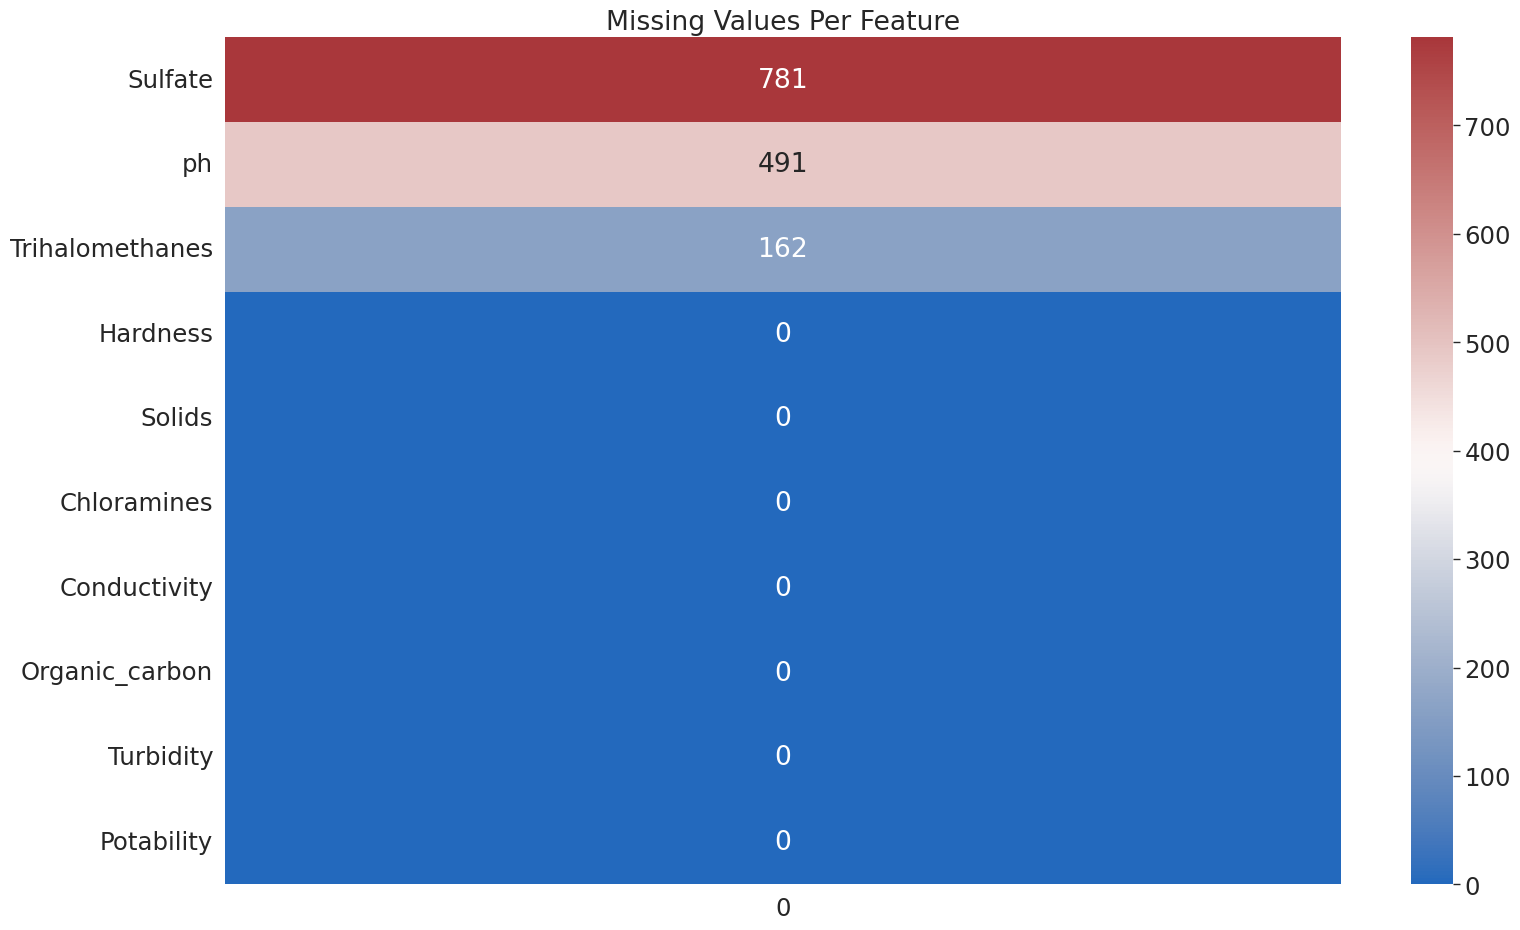

In [ ]:
#representation
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

We will impute the outliers in our data using the corresponding mean to label, i.e., all missing values that are labeled "potable" will be imputed using the mean of all non-missing "potable" samples, and the same action will be applied to "non-potable" samples with missing values.

In [ ]:
# Impute Missing Values with Label Matching Mean
for col in ['Sulfate','ph','Trihalomethanes']:
    missing_label_0 = df.query('Potability == 0')[col][df[col].isna()].index
    df.loc[missing_label_0,col] = df.query('Potability == 0')[col][df[col].notna()].mean()

    missing_label_1 = df.query('Potability == 1')[col][df[col].isna()].index
    df.loc[missing_label_1,col] = df.query('Potability == 1')[col][df[col].notna()].mean()

###**Step 4)** Exploratory Data Analysis
Exploratory Data Analysis (EDA) is a step in the Data Analysis Process, where a number of techniques are used to better understand the dataset being used.

In this step, we will perform the below operations:
1. Head of the dataset
2. The shape of the dataset
3. List types of all columns
4. Info of the dataset
5. Summary of the dataset

###1)Head of dataset

In [ ]:
# Display first five records of data
df.head()



,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Display last five records of the data
df.tail()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,332.566990,392.449580,19.903225,66.539684,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,332.566990,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,332.566990,402.883113,11.168946,77.488213,4.708658,1
3275,7.874671,195.102299,17404.177061,7.509306,332.566990,327.459760,16.140368,78.698446,2.309149,1


In [ ]:
# Display randomly any number of records of data
df.sample(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2985,7.085378,188.445469,28791.614416,8.040356,382.009477,422.234861,10.575690,63.235365,3.228379,0
752,5.699873,159.435601,31977.370137,5.249974,332.566990,501.743218,8.008011,55.870245,2.416402,1
2593,7.539338,227.316128,12610.936307,9.507585,345.139235,343.242711,12.769070,82.826282,5.114129,0
1859,7.480728,117.057314,28357.942774,4.702821,414.855784,472.059339,18.340212,76.344581,3.714875,0
2511,9.824706,218.019530,15120.924716,3.124833,334.564290,498.933519,14.836624,42.168234,3.226035,0
2759,6.920449,196.319401,39251.182129,8.493784,317.382315,487.504368,14.697845,41.753727,4.498818,1
2246,5.573201,229.174987,15613.160533,4.157902,383.481116,409.066577,10.751904,63.758516,3.599625,0
2730,7.073783,160.095086,26561.569491,7.187022,322.090465,372.623529,11.455203,57.150958,5.136780,1
2587,5.708517,187.081758,12193.611261,8.288505,351.573257,577.402810,14.357648,66.303555,3.344285,0
2792,7.073783,222.268721,18406.594176,8.183988,332.566990,395.448799,9.475981,79.852330,3.710958,1


###2)The shape of the dataset

In [ ]:
#Number of rows and columns
df.shape

(3276, 10)

###3)List types of all columns

In [ ]:
#List the types of all columns.
df.dtypes

,0
ph,float64
Hardness,float64
Solids,float64
Chloramines,float64
Sulfate,float64
Conductivity,float64
Organic_carbon,float64
Trihalomethanes,float64
Turbidity,float64
Potability,int64


###4)Info of the dataset

In [ ]:
#finding out if the dataset contains any null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


###5)Summary of the dataset

In [ ]:
# Statistical summary
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080855,196.369496,22014.092526,7.122277,333.785123,426.205111,14.284970,66.395671,3.966786,0.390110
std,1.469958,32.879761,8768.570828,1.583085,36.145701,80.824064,3.308162,15.769901,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.085378,196.967627,20927.833607,7.130299,334.564290,421.884968,14.218338,66.303555,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


### **Step 5)** Data Visualization

###1)Pie chart

In [ ]:
#Distribution of variable over pie chart
T = df.copy()
T['Potability'] = T['Potability'].map({1: 'Potable', 0: 'Not Potable'})
fig = px.pie(T, names='Potability', title='Distribution of Target Labels (Drinkability)')
fig.show()

Observation: We see that we have some degree of unbalancedness in our data; we will not apply any upsampling/downsampling methodology as the proportions are more close to equal than to be extremely balanced (cases like 90% / 10% where upsampling is crucial). Also, the more significant label ("Not potable") is the one with more samples; logically, we would prefer a model that will have more false negatives rather than a model that has more false positives.

###2)Correlation coefficients

In [ ]:
#correlation coefficients
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=('Pearson Correlation', 'Spearman Correlation', 'Kendall Correlation')
)

colorscale = [
    [1.0, "rgb(165,0,38)"],
    [0.8888888888888888, "rgb(215,48,39)"],
    [0.7777777777777778, "rgb(244,109,67)"],
    [0.6666666666666666, "rgb(253,174,97)"],
    [0.5555555555555556, "rgb(254,224,144)"],
    [0.4444444444444444, "rgb(224,243,248)"],
    [0.3333333333333333, "rgb(171,217,233)"],
    [0.2222222222222222, "rgb(116,173,209)"],
    [0.1111111111111111, "rgb(69,117,180)"],
    [0.0, "rgb(49,54,149)"]
]

# Pearson correlation
pearson_corr = df.corr('pearson')
fig.add_trace(
    go.Heatmap(
        x=pearson_corr.columns,
        y=pearson_corr.index,
        z=pearson_corr.values,
        showscale=False,
        xgap=1, ygap=1,
        colorscale=colorscale
    ),
    row=1, col=1
)

# Spearman correlation
spearman_corr = df.corr('spearman')
fig.add_trace(
    go.Heatmap(
        x=spearman_corr.columns,
        y=spearman_corr.index,
        z=spearman_corr.values,
        xgap=1, ygap=1,
        colorscale=colorscale
    ),
    row=2, col=1
)

# Kendall correlation
kendall_corr = df.corr('kendall')
fig.add_trace(
    go.Heatmap(
        x=kendall_corr.columns,
        y=kendall_corr.index,
        z=kendall_corr.values,
        showscale=False,
        xgap=1, ygap=1,
        colorscale=colorscale
    ),
    row=3, col=1
)

fig.update_layout(height=700, width=1100, title_text="Different Inner Correlation Coefficients")
fig.show()

Observation: It appears that there is no linear/ranked correlation between our output label and our features, mostly due to the fact that we have a binary label and continuous features, traditional linear correlation coefficients won't tell us the true underlying story about the relationships between our features and the target variable. Later in this notebook, we will perform more in depth analysis to try and uncover some of the relationships hidden in our data.

###3)Distribution of variables

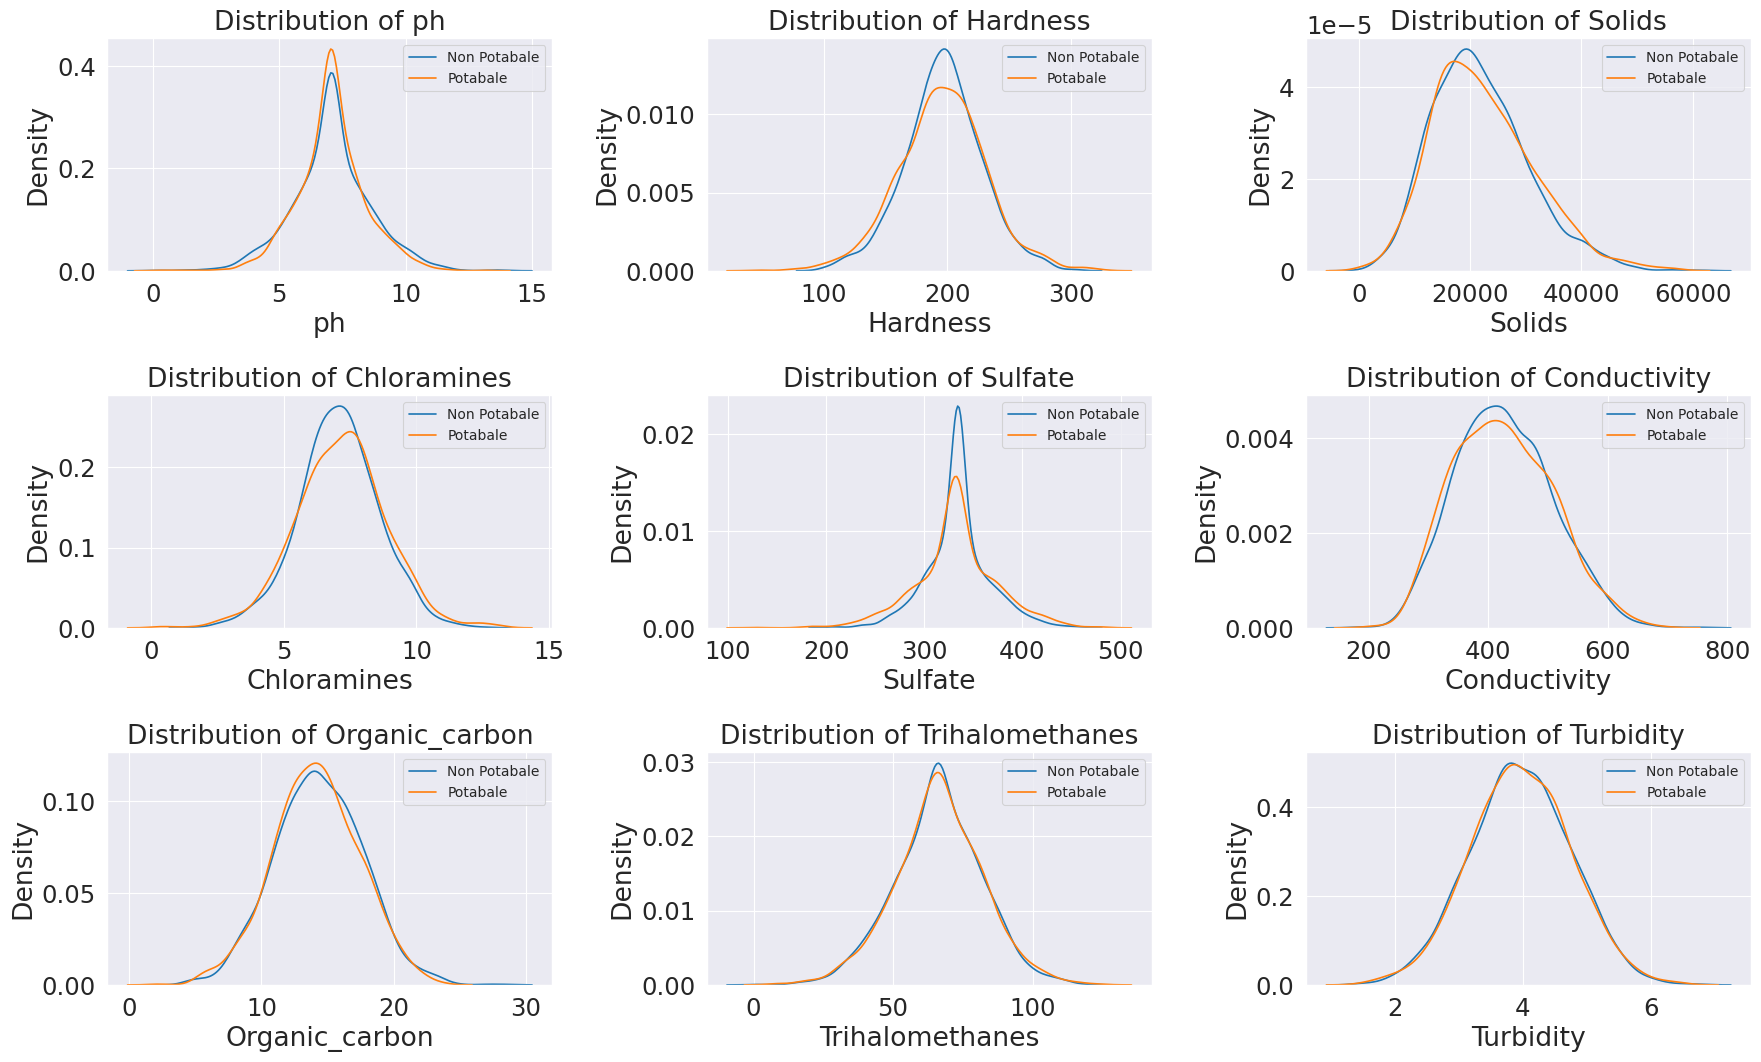

In [ ]:
#Distribution of potatbility and non potability over all variables
non_potabale = df.query('Potability == 0')
potabale     = df.query('Potability == 1')

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {col}')
    sns.kdeplot(x=non_potabale[col],label='Non Potabale')
    sns.kdeplot(x=potabale[col],label='Potabale')
    plt.legend(prop=dict(size=10))

plt.tight_layout()

Observation: Looking at the distribution of all our features divided by our target label, we see that some of them have some difference, a key point that can help us select the features with which we will train our models. To better understand the differences between the features with respect to the target label, a more robust analysis is required to confirm any hypothesis we may have at this point just from looking at the distribution plots.

###4)Statistical difference analysis

In [ ]:
#T-test
ttest_results_pvalues,ttest_results_statistic = [],[]
for ax,col in enumerate(df.columns[:9]):
    statistic,pvalue = ttest_ind(non_potabale[col],potabale[col])
    ttest_results_pvalues.append(pvalue)
    ttest_results_statistic.append(statistic)

ttest_res_df = pd.DataFrame({'S':ttest_results_statistic,'P':ttest_results_pvalues,'F':df.columns[:9]}) # Changed f to df
ttest_res_df = ttest_res_df.sort_values(by='P')

Explanation: In order to test for any significant difference between "potable" and "non-potable" water samples, we will treat both labels as two separate populations from which we sampled 'n' and 'k' samples (n = the number of "potable" samples, 'k' = the number of "non-potable" samples). We will perform a two-tailed t-test to check if there is any significant difference between the two sample means, considering the sample size differences and unequal variance. We expect to see low p-values for the features that indeed are significantly different between the labels. We will set our significance level alpha to be equal to or less than 0.1.

In [ ]:
#Plotting T-test
tr  = go.Bar(x=ttest_res_df['F'] ,y=ttest_res_df['P'] ,name='T-test P Value')
tr2 = go.Bar(x=ttest_res_df['F'] ,y=ttest_res_df['S'] ,name='T-test F Statistic')

data = [tr2,tr]
fig = go.Figure(data=data,layout={'title':'T-test Results For Each Feature in Our Dataset','barmode':'overlay'})
fig.show()

Observation: After performing the two-tailed t-test, we see that only "Solids" and "Organic carbon" have p-values below our pre-defined alpha value, even though there are two more features closer to our alpha level than the other 4. When we get to the modeling stage, the 4 features we will use will be all the features we see in the above plot with p-values below 0.18 (first 4 features in the plot)

### 5)Bar graph

In [ ]:
#Mutual Information Between Our Features and Potability
mutual_info = []
for i in range(0,9):
    mi = mutual_info_classif(X=df.iloc[:,i].to_numpy().reshape(-1, 1),y=df.iloc[:,-1],random_state=42)
    mutual_info.append(mi[0])
mutual_info = pd.DataFrame({'Feature':df.columns[:9],'MI':mutual_info})
mutual_info = mutual_info.sort_values(by='MI')
tr  = go.Bar(x=mutual_info['Feature'] ,y=mutual_info['MI'] ,name='Mutual Information')

data = [tr]
fig = go.Figure(data=data,layout={'title':'Mutual Information Between Our Features and Potability','barmode':'overlay','yaxis_title':'Mutal Information'})
fig.show()

Observation: As an additional metric for consideration, we use "Mutal Information" to test and see if there is any similarity between the probability distribution of or continuous features with the Bernoulli distribution that represent our target. We see that some of the worst scoring features in our t-test have the highest mutual information with our target label, conceptually meaning that knowing something about "Ph" decreases my uncertainty in assuming about "Potability," unfortunately, mutual information doesn't tell me exactly to what assumption does "Ph" contribute. Still, none the less it is an indicator of relationship and a strong what in the matter, so we will indeed include it as well in our modeling section.

### 6)Probabilistic inference

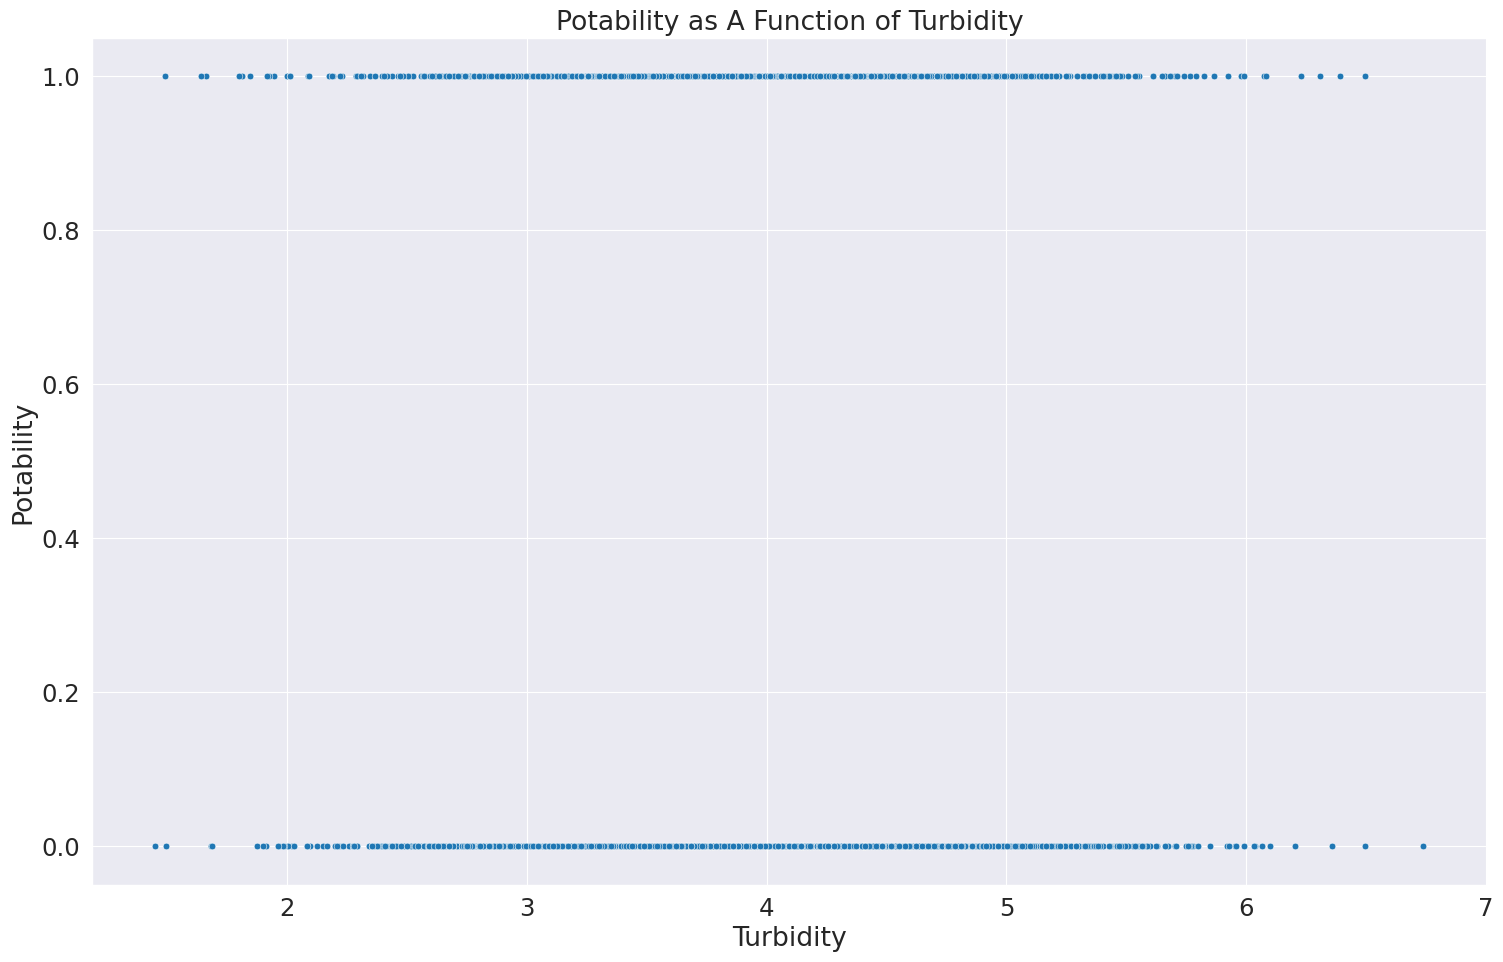

In [ ]:
#Relation between turbidity and potability as its function
plt.title('Potability as A Function of Turbidity')
sns.scatterplot(x=df.iloc[:,8],y=df.iloc[:,-1])
plt.show()

It hard to tell whether the probability of a water sample being potable increases as the turbidity increases. We are interested in modeling the probability here. The best we can do is ask, "At turbidity Value X, what is the probability of a water sample being potable?". The goal of the following experiment is that question.

We need a function of turbidity, call it p(X), that is bounded between 0 and 1 and changes from 1 to 0 as we increase turbidity. Such a function is well defined and known to us all, the logistic function.

p(X)=1 / ( 1 + e ^ (βX) )

In this model, β is the variable we are uncertain about.
Sample is Potabale, Mᵢ ∼ Ber (P (turbidityᵢ ) ) , i=1..N

where  p(turbidity) is our logistic function and turbidityᵢ are the turbidity values in our dataset.

### 7)Domain Analysis via Dimensionality Recduction

In [ ]:
#Domain Analysis
N=5
pca_pipeline = Pipeline(steps = [
    ('scale',StandardScaler()),
    ('PCA',PCA(N))
])

tf_data = pca_pipeline.fit_transform(df.iloc[:,:9])
tf_data = pd.DataFrame({'PC1':tf_data[:,0],'PC2':tf_data[:,1],'PC3':tf_data[:,2],'PC4':tf_data[:,3],'PC5':tf_data[:,4],
                        'label':df.iloc[:,-1].map({0:'Not Potabale',1:'Potable'})})
px.scatter_3d(tf_data,x='PC1',y='PC2',z='PC3',color='label',color_discrete_sequence=['salmon','green'],title=r'$\textit{Data in Reduced Dimension } R^9 \rightarrow R^3$')

Observation: After using Principal Components Analysis to reduce the dimensionality of our data from R9 to R3, we see no visible linear/polynomial separation between the labels, a key point that decreases our belief in models that exist rely heavily on spatial separation like SVM.

In [ ]:
#Data spread across 2D Combination
components = tf_data[['PC1','PC2','PC3','PC4','PC5']].to_numpy()
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca_pipeline['PCA'].explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(N),
    color=tf_data['label'],
    color_discrete_sequence=['salmon','green']
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(title='Data Spread Based on Different 2D Combinations of Principal Components')

fig.show()

In [ ]:
evr = pca_pipeline['PCA'].explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance",
    "type": "bar",
    'y':evr}
trace2 = {
    "name": "cumulative explained variance",
    "type": "scatter",
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"},
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title='{:.2f}% of the Original Feature Variance Can Be Explained Using {} Dimensions'.format(np.sum(evr)*100,N))
fig.show()

Observation: Using five components (out of initially 9), we can see that we can only preserve 60 percent of the original variance; we can learn from this fact that our features are indeed uncorrelated between them and there is no linear combination that can tell us a better story regarding the target label after looking at the different permutations of principal components.

###**Step 6) Model Selection**


In [ ]:
features = ttest_res_df.iloc[:3,:].F.to_list()
features.append('Turbidity')
train_x,test_x,train_y,test_y = train_test_split(df[features],df.iloc[:,-1],random_state=42,shuffle=True)

Explanation: The feature we select for our modeling stage are all the features we tested during our EDA section and found evidence of some difference or relationship to the / with respect to the target label.

In [ ]:
RandomForest_Pipeline     = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
AdaBoost_Pipeline         = Pipeline(steps = [('scale',StandardScaler()),('AB',AdaBoostClassifier(random_state=42))])
SVC_Pipeline              = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])

RandomForest_CV_f1     = cross_val_score(RandomForest_Pipeline,df[features],df.iloc[:,-1],cv=10,scoring='f1')
AdaBoost_CV_f1         = cross_val_score(AdaBoost_Pipeline,df[features],df.iloc[:,-1],cv=10,scoring='f1')
SVC_CV_f1              = cross_val_score(SVC_Pipeline,df[features],df.iloc[:,-1],cv=10,scoring='f1')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: Fu

Explanation: Our baseline model will be a Random Forest model as it can provide us with a separation of our domain that is nor linear and not polynomial; we will also see if AdaBoost using a decision tree that is conceptually similar to the Random Forest model will be able to provide us with some interesting results. The third model test in this baseline section is a classifier based on SVM, and that is to confirm the hypothesis stated earlier that our data is not separable in higher dimensions.

In [ ]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles=('Random Forest Cross Val Scores',
                                                                     'AdaBoost Cross Val Scores',
                                                                     'SVM Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=np.arange(0,len(SVC_CV_f1)),y=RandomForest_CV_f1,name='Random Forest'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(SVC_CV_f1)),y=AdaBoost_CV_f1,name='AdaBoost'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(SVC_CV_f1)),y=SVC_CV_f1,name='SVM'),
    row=3, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Baseline Models 10 Fold Cross Validation")
fig.update_yaxes(title_text="RMSE")


fig.show()

Observation: As expected, we see some fair results both in our baseline Random Forest model and our baseline AdaBoost model. Considering these results, we will try to create a more accurate and optimized model by using AdaBoost to invoke Random Forest models as its base estimators.

Notice that the SVM classifier indeed does an awful job confirming our hypothesis.

In [ ]:
RFBE = RandomForestClassifier(random_state=42)

AdaBoost_Pipeline = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('AB', AdaBoostClassifier(random_state=42, base_estimator=RFBE))
])

AdaBoost_Pipeline.fit(train_x, train_y)

parameters = {
    'AB__base_estimator__max_depth': [2, 3, 5],
    'AB__base_estimator__min_samples_leaf': [2, 5, 10],
    'AB__base_estimator__criterion': ['entropy', 'gini'],
    'AB__base_estimator__bootstrap': [True, False],
    'AB__n_estimators': [5, 10, 25],
    'AB__learning_rate': [0.01, 0.1]
}

ADA_RF_GS = GridSearchCV(AdaBoost_Pipeline, parameters, cv=3, verbose=10)
ADA_RF_GS.fit(df[features], df.iloc[:, -1])

print("Best parameter (CV score=%0.3f):" % ADA_RF_GS.best_score_)
print(ADA_RF_GS.best_params_)

In [ ]:
# RFBE = RandomForestClassifier(random_state=42)

# AdaBoost_Pipeline         = Pipeline(steps = [('scale',StandardScaler()),('AB',AdaBoostClassifier(random_state = 42, base_estimator=RFBE))                                                                                           base_estimator = RFBE))])

# AdaBoost_Pipeline.fit(train_x,train_y)

# parameters = {'AB__base_estimator__max_depth':[2,3,5],
#               'AB__base_estimator__min_samples_leaf':[2,5,10],
#               'AB__base_estimator__criterion':['entropy','gini'],
#               'AB__base_estimator__bootstrap':[True,False],
#               'AB__n_estimators':[5,10,25],
#               'AB__learning_rate':[0.01,0.1]}

# ADA_RF_GS  = GridSearchCV(AdaBoost_Pipeline,parameters,cv=3,verbose=10)
# ADA_RF_GS.fit(water_df[features],water_df.iloc[:,-1])

# print("Best parameter (CV score=%0.3f):" % ADA_RF_GS.best_score_)
# print(ADA_RF_GS.best_params_)

Due to the reasonably long search time consumed by Grid Search, this block is commented.The result of the grid search is given below.Screenshot-2021-06-27-143926.jpg

In [ ]:
{'AB__base_estimator__bootstrap': True,
 'AB__base_estimator__criterion': 'gini',
 'AB__base_estimator__max_depth': 5,
 'AB__base_estimator__min_samples_leaf': 10,
 'AB__learning_rate': 0.01,
 'AB__n_estimators': 5}

###Final Model

In [ ]:
RFBE = RandomForestClassifier(random_state=42,bootstrap=True,criterion='gini',max_depth=5,min_samples_leaf=10)
AdaBoost_Pipeline         = Pipeline(steps = [('scale',StandardScaler()),('AB',AdaBoostClassifier(random_state = 42,
                                                                                                 base_estimator = RFBE,
                                                                                                 learning_rate=0.01,
                                                                                                 n_estimators=5))])

AdaBoost_Pipeline.fit(train_x,train_y)
f1 = AdaBoost_Pipeline.score(test_x,test_y)
print('F1 - Score of AdaBoost Model with Random Forest Base Estimators and Cross Validation Grid Search -[',np.round(f1,2),']')